In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from latex import latexify
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


In [3]:
def generate_xor_dataset(size):
    centers = [[-3.5, 3.5], [-3.5, -3.5], [3.5, -3.5], [3.5, 3.5]]
    X, _ = make_blobs(n_samples = size, centers = centers, n_features = 2, random_state = 13, cluster_std = 2)
    X = torch.FloatTensor(X)
    y = (X[:, 0] > 0) ^ (X[:, 1] > 0)
    return X, y.float().view(-1, 1)

## **Plotting the XOR Dataset**

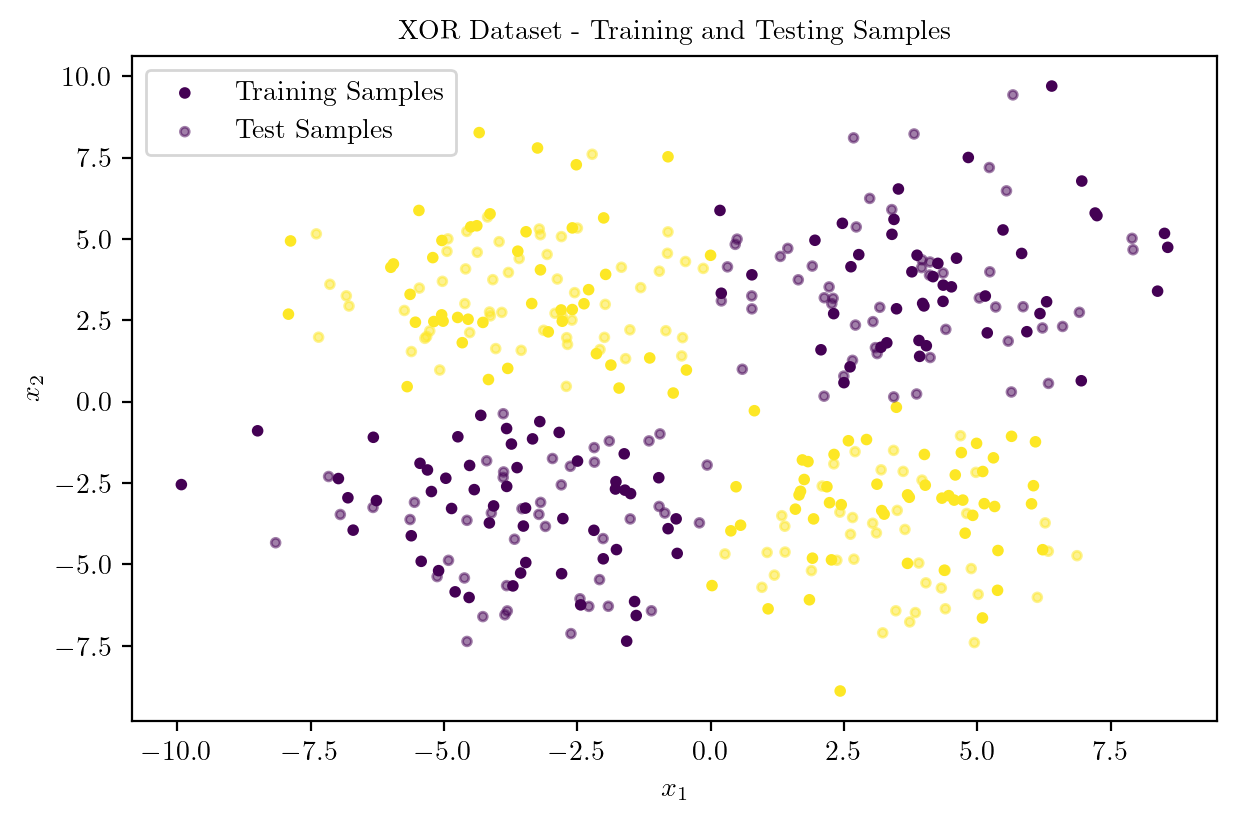

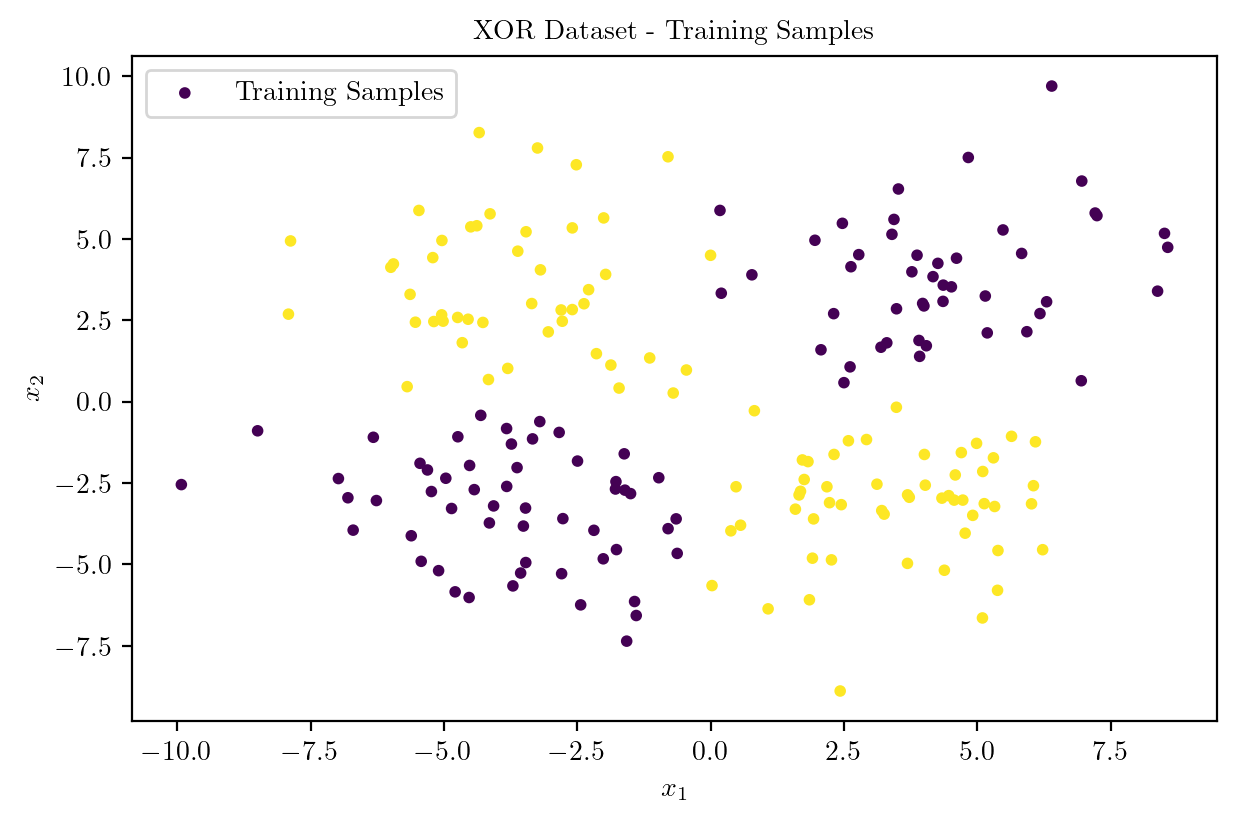

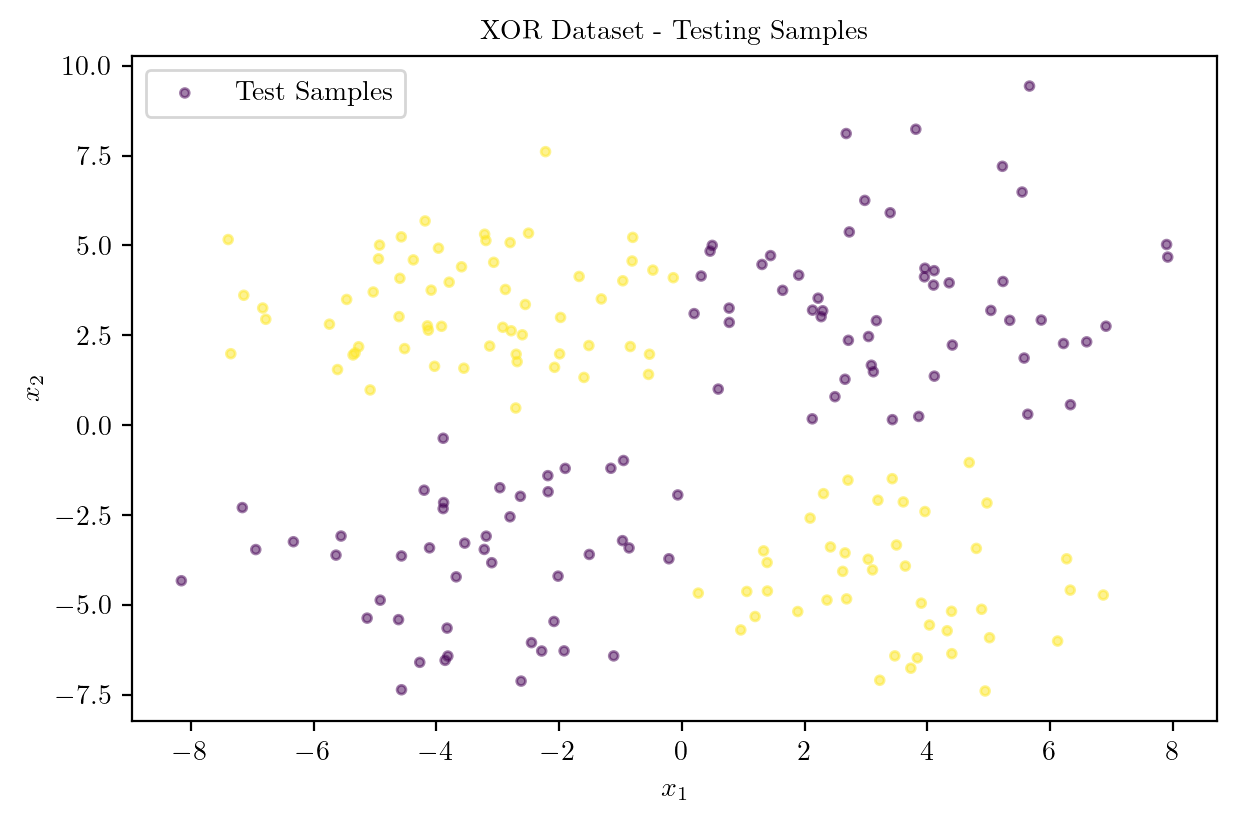

In [4]:
X, y = generate_xor_dataset(400)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)
latexify(columns = 2, fig_width = 7)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = "viridis", s = 10, label = "Training Samples")
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = "viridis", s = 10, label = "Test Samples", alpha = 0.5)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("XOR Dataset - Training and Testing Samples")
plt.legend()
plt.show()

plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = "viridis", s = 10, label = "Training Samples")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("XOR Dataset - Training Samples")
plt.legend()
plt.show()


plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = "viridis", s = 10, label = "Test Samples", alpha = 0.5)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("XOR Dataset - Testing Samples")
plt.legend()
plt.show()

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([200, 2]),
 torch.Size([200, 2]),
 torch.Size([200, 1]),
 torch.Size([200, 1]))

In [6]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# **Template Model Architechture**
![](./media/MLP_XOR.svg)

In [7]:
class XORMLP(nn.Module):
  def __init__(self, hidden_layer1, hidden_layer2):
    super().__init__()
    self.lin1 = nn.Linear(2, hidden_layer1)
    self.lin2 = nn.Linear(hidden_layer1, hidden_layer2)
    self.lin3 = nn.Linear(hidden_layer2, 1)

  def forward(self, x):
    x = torch.relu(self.lin1(x))
    x = torch.relu(self.lin2(x))
    logits = self.lin3(x)
    return logits

### $$\text{Hidden Layer 1} = 3$$
### $$\text{Hidden Layer 2} = 2$$
![](./media/MLP_XORSimple.svg)
![](./media/SimpleMLP.png)

In [8]:
model = XORMLP(hidden_layer1 = 3, hidden_layer2 = 2)

In [9]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

lin1.weight torch.Size([3, 2])
lin1.bias torch.Size([3])
lin2.weight torch.Size([2, 3])
lin2.bias torch.Size([2])
lin3.weight torch.Size([1, 2])
lin3.bias torch.Size([1])


In [10]:
model.state_dict()

OrderedDict([('lin1.weight',
              tensor([[-0.2976,  0.6282],
                      [-0.6134, -0.3217],
                      [ 0.6922,  0.4466]])),
             ('lin1.bias', tensor([ 0.4762, -0.5784,  0.0026])),
             ('lin2.weight',
              tensor([[ 0.0046,  0.1216,  0.3816],
                      [-0.1370,  0.3428,  0.3598]])),
             ('lin2.bias', tensor([0.2782, 0.0057])),
             ('lin3.weight', tensor([[ 0.5593, -0.6973]])),
             ('lin3.bias', tensor([0.6864]))])

## **Model Training with NO REGULARIZATION**
$$\text{Loss Function} = \text{Binary Cross Entropy with Logits} $$
$$L_N = - [y_N \cdot \log({\sigma(\hat{y}_N)}) + (1 - y_N) \cdot \log({1 - \sigma(\hat{y}_N)})]$$
$$ \sigma(z) = \frac{1}{1 + e^{-z}}$$

In [11]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.03)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)

for epoch in range(10000):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        logits = model(inputs)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        correct += ((logits > 0) == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    accuracy = correct / total
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch + 1}/10000] | Loss: {epoch_loss} | Accuracy: {accuracy:.7f}")

Epoch [1000/10000] | Loss: 0.00685104366084488 | Accuracy: 1.0000000
Epoch [2000/10000] | Loss: 0.010137872404876751 | Accuracy: 0.9950000
Epoch [3000/10000] | Loss: 0.013913234437737287 | Accuracy: 0.9950000
Epoch [4000/10000] | Loss: 0.030130560642868502 | Accuracy: 0.9950000


KeyboardInterrupt: 

## **Inference from the Model on Training Samples**

In [12]:
model.eval()

with torch.no_grad():
    logits = model(X_test)
    predictions = (logits > 0).float()
    accuracy = (predictions == y_test).sum().item() / y_test.size(0)
    print(f"Test Accuracy: {accuracy:.7f}")

Test Accuracy: 0.9650000


## **Plotting the Decision Surface**

In [13]:
def plot_decision_boundary(X_train, X_test, y_train, y_test, model, title):
    X = torch.cat([X_train, X_test], dim = 0).cpu().numpy()
    y = torch.cat([y_train, y_test], dim = 0).cpu().numpy()
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device))
    
    Z = (Z > 0).float().cpu().numpy().reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap = plt.cm.Paired, alpha = 0.4)
    
    plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = "viridis", s = 10)
    plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = "viridis", s = 10, alpha = 0.5)
    
    yellow_patch = mpatches.Patch(color = "yellow", label = "Class 1")
    blue_patch = mpatches.Patch(color = "darkblue", label = "Class 2")
    pink_patch = mpatches.Patch(color = "darksalmon", label = "Predict Class 1")
    lblue_patch = mpatches.Patch(color = "lightblue", label = "Predict Class 2")
    plt.legend(handles = [yellow_patch, blue_patch, pink_patch, lblue_patch], loc = "upper center", bbox_to_anchor = (0.5, 1.25), ncol = 2, fancybox = True, shadow = True)
    
    plt.title(title)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.show()

### **Decision Boundary before training**

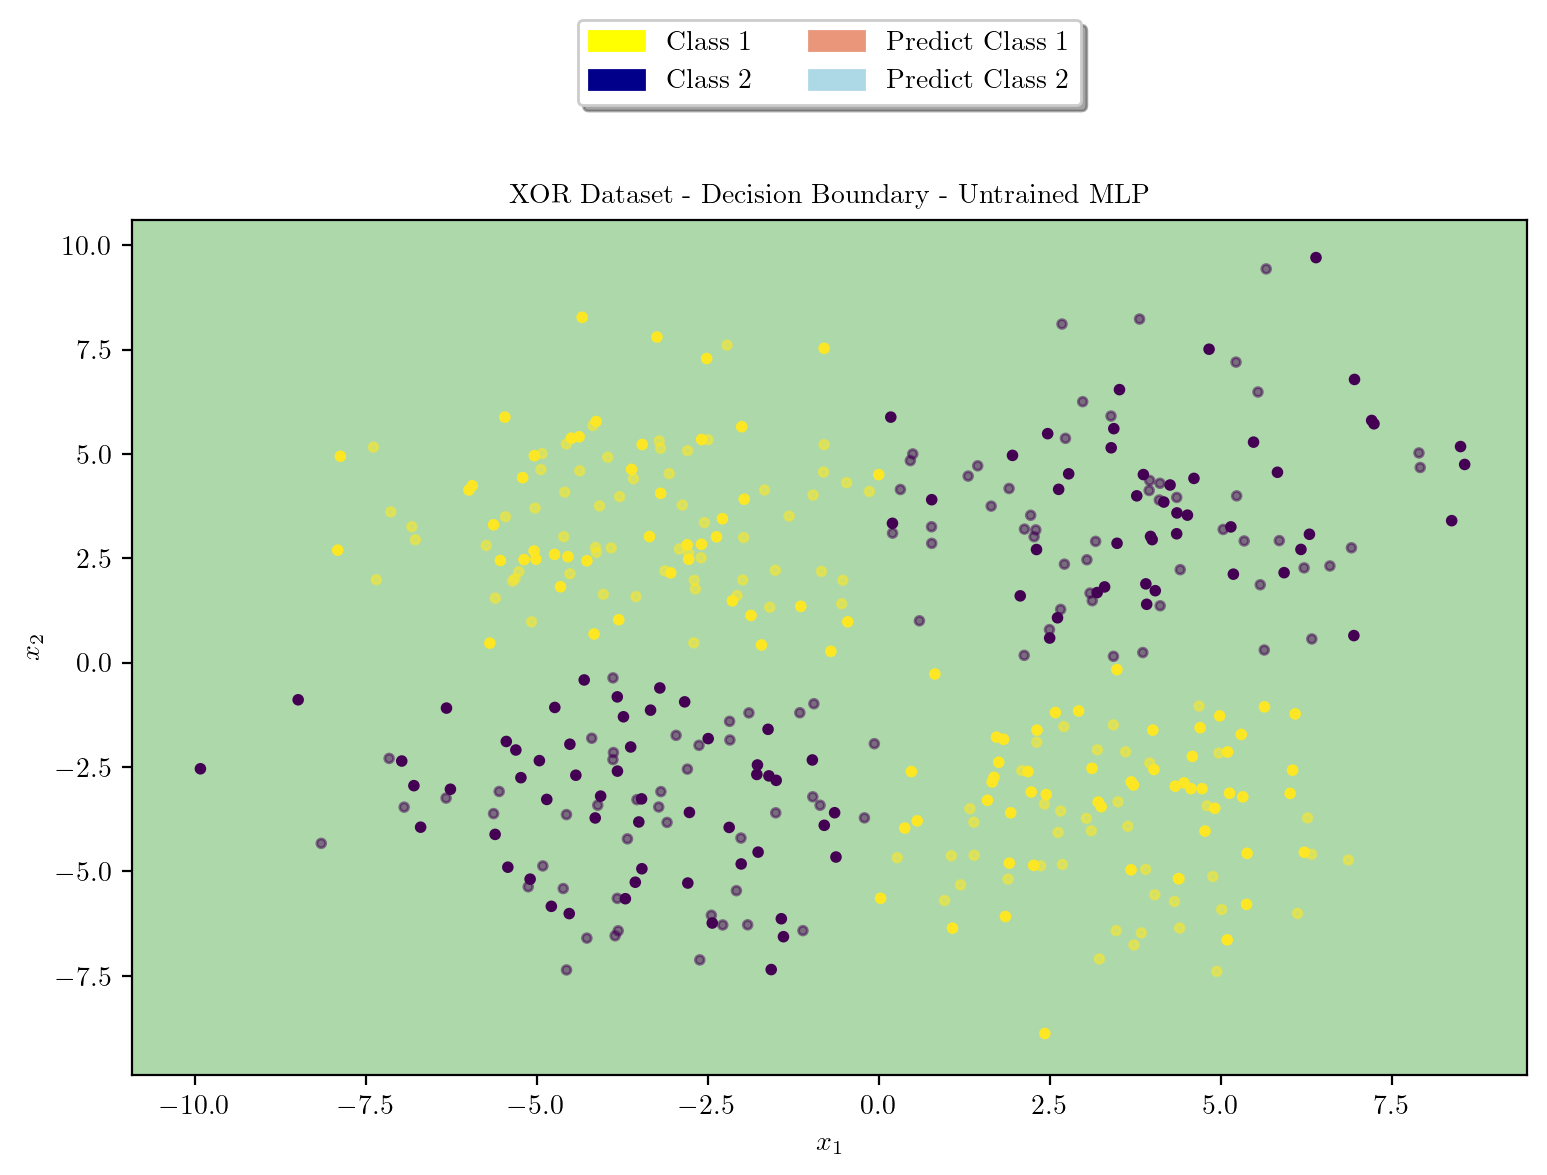

In [15]:
latexify(columns = 2, fig_width = 9)
model = XORMLP(hidden_layer1 = 3, hidden_layer2 = 2)
plot_decision_boundary(X_train, X_test, y_train, y_test, model, "XOR Dataset - Decision Boundary - Untrained MLP")

### **Decision Boundary After Training**

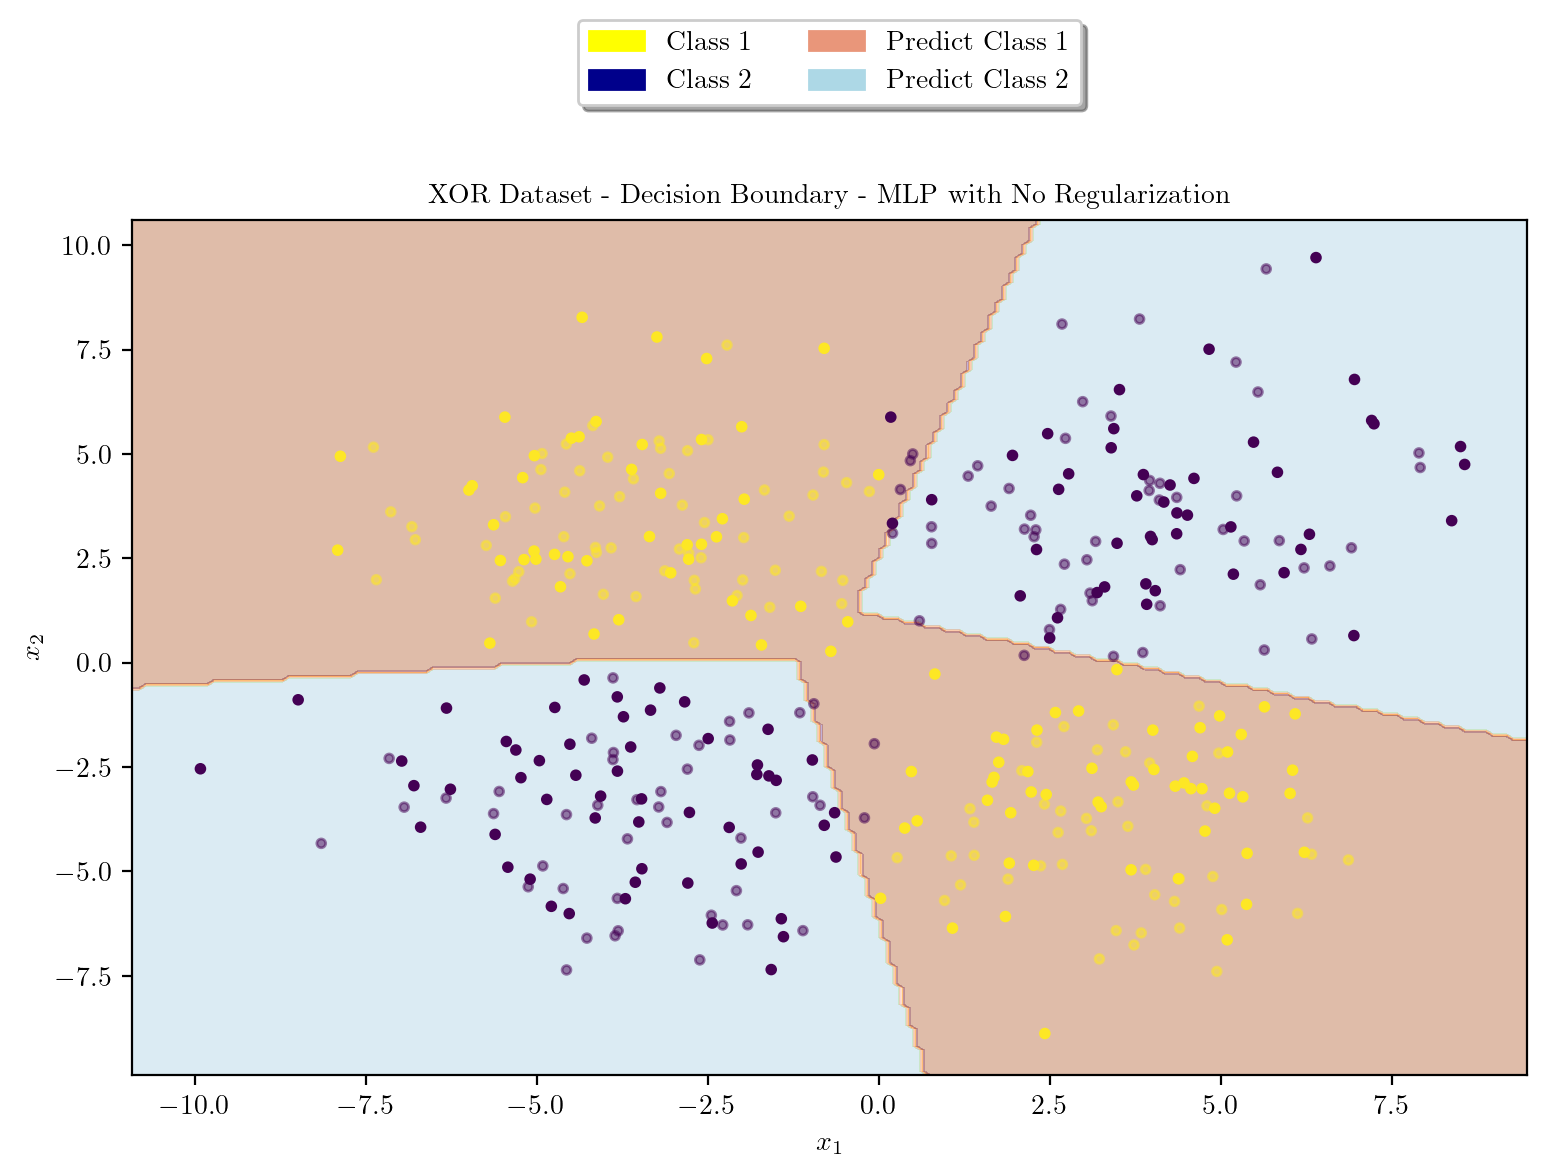

In [14]:
latexify(columns = 2, fig_width = 9)
plot_decision_boundary(X_train, X_test, y_train, y_test, model, "XOR Dataset - Decision Boundary - MLP with No Regularization")

# **Model Architechture $L_1$ regularization**

In [16]:
class XORMLP1(nn.Module):
  def __init__(self, hidden_layer1):
    super().__init__()
    self.lin1 = nn.Linear(2, hidden_layer1)
    self.lin2 = nn.Linear(hidden_layer1, 1)

  def forward(self, x):
    x = torch.relu(self.lin1(x))
    logits = self.lin2(x)
    return logits

### $$\text{Hidden Layer 1} = 3$$
![](./media/MLP_XORL1.svg)
![](./media/SimpleMLPL1.png)

In [17]:
model = XORMLP1(hidden_layer1 = 3)

In [18]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

lin1.weight torch.Size([3, 2])
lin1.bias torch.Size([3])
lin2.weight torch.Size([1, 3])
lin2.bias torch.Size([1])


In [19]:
model.state_dict()

OrderedDict([('lin1.weight',
              tensor([[ 0.5688,  0.6496],
                      [ 0.3606,  0.3339],
                      [-0.1416, -0.6634]])),
             ('lin1.bias', tensor([ 0.4078,  0.1093, -0.6498])),
             ('lin2.weight', tensor([[ 0.3939, -0.3843,  0.4741]])),
             ('lin2.bias', tensor([0.5283]))])

## **Model Training with $L_1$ Regularization**
$$\text{Loss Function} = \text{Binary Cross Entropy with Logits} + \beta \cdot \sum_{i} ||w_i^T w_i||_1$$
$$L_N = - [y_N \cdot \log({\sigma(\hat{y}_N)}) + (1 - y_N) \cdot \log({1 - \sigma(\hat{y}_N)})] + \beta \cdot \sum_{i} ||w_i^T w_i||_1$$
$$ \sigma(z) = \frac{1}{1 + e^{-z}}$$

In [23]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.03)

# L1 Regularization Penalty Coefficient
beta = 0.001

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)

for epoch in range(10000):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        logits = model(inputs)
        loss = loss_fn(logits, labels)
        
        l1_regularization = 0.0
        for param in model.parameters():
            l1_regularization += torch.norm(param, 1)
        loss += beta * l1_regularization
        
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        correct += ((logits > 0) == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    accuracy = correct / total
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch + 1}/10000] | Loss: {epoch_loss} | Accuracy: {accuracy:.7f}")

Epoch [1000/10000] | Loss: 0.03956269845366478 | Accuracy: 1.0000000
Epoch [2000/10000] | Loss: 0.0414457523397037 | Accuracy: 1.0000000


KeyboardInterrupt: 

In [24]:
model.eval()

with torch.no_grad():
    logits = model(X_test)
    predictions = (logits > 0).float()
    accuracy = (predictions == y_test).sum().item() / y_test.size(0)
    print(f"Test Accuracy: {accuracy:.7f}")

Test Accuracy: 1.0000000


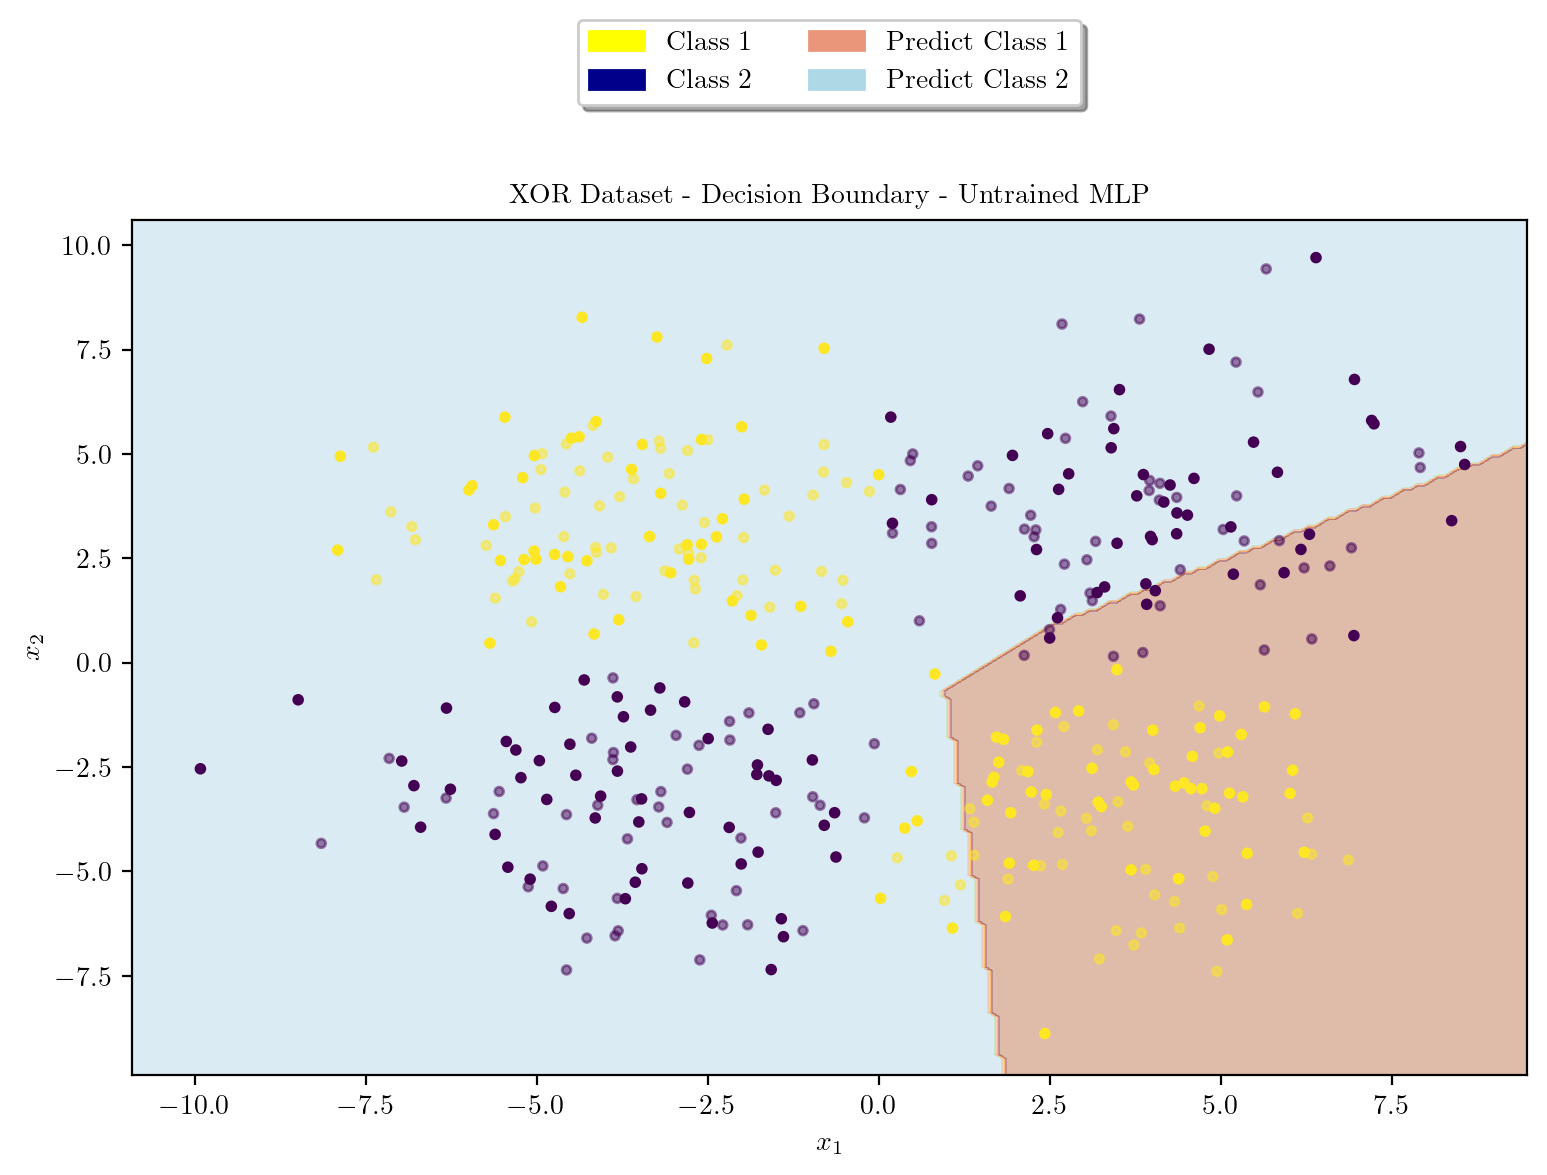

In [26]:
latexify(columns = 2, fig_width = 9)
model = XORMLP1(hidden_layer1 = 3)
plot_decision_boundary(X_train, X_test, y_train, y_test, model, "XOR Dataset - Decision Boundary - Untrained MLP")

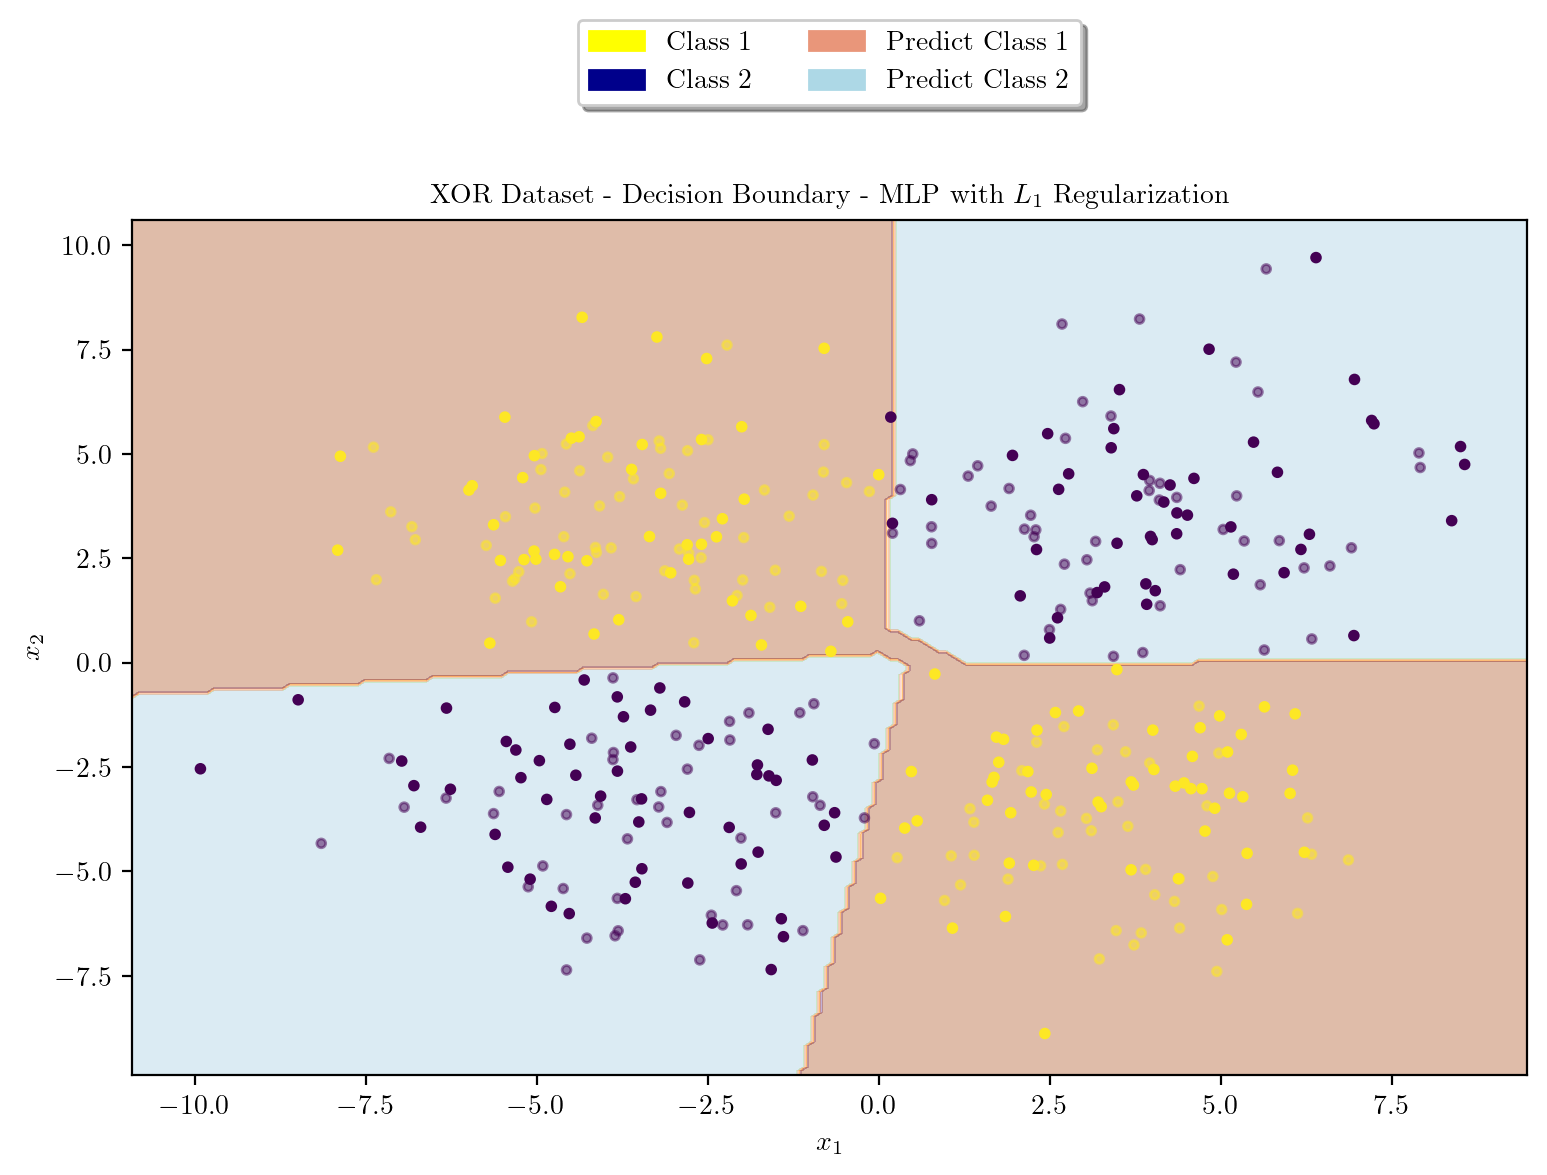

In [25]:
latexify(columns = 2, fig_width = 9)
plot_decision_boundary(X_train, X_test, y_train, y_test, model, r"XOR Dataset - Decision Boundary - MLP with $L_1$ Regularization")

# **Model Architechture $L_2$ regularization**

### $$\text{Hidden Layer 1} = 3$$
### $$\text{Hidden Layer 2} = 2$$
![](./media/SimpleMLPL2.png)

In [27]:
model = XORMLP(hidden_layer1 = 3, hidden_layer2 = 2)

In [28]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

lin1.weight torch.Size([3, 2])
lin1.bias torch.Size([3])
lin2.weight torch.Size([2, 3])
lin2.bias torch.Size([2])
lin3.weight torch.Size([1, 2])
lin3.bias torch.Size([1])


In [29]:
model.state_dict()

OrderedDict([('lin1.weight',
              tensor([[-0.5864,  0.4664],
                      [ 0.2003,  0.3591],
                      [ 0.3527, -0.0656]])),
             ('lin1.bias', tensor([ 0.6405, -0.6505, -0.1879])),
             ('lin2.weight',
              tensor([[-0.3094, -0.5630,  0.2797],
                      [ 0.3200,  0.3753,  0.1707]])),
             ('lin2.bias', tensor([-0.5447, -0.0784])),
             ('lin3.weight', tensor([[0.2790, 0.2802]])),
             ('lin3.bias', tensor([0.3829]))])

## **Model Training with $L_2$ Regularization**
$$\text{Loss Function} = \text{Binary Cross Entropy with Logits} + \beta \cdot \sum_{i} ||w_i^T w_i||_2$$
$$L_N = - [y_N \cdot \log({\sigma(\hat{y}_N)}) + (1 - y_N) \cdot \log({1 - \sigma(\hat{y}_N)})] + \beta \cdot \sum_{i} ||w_i^T w_i||_2$$
$$ \sigma(z) = \frac{1}{1 + e^{-z}}$$

In [30]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.03)

# L2 Regularization Penalty Coefficient
beta = 0.001

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)

for epoch in range(10000):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        logits = model(inputs)
        loss = loss_fn(logits, labels)
        
        l1_regularization = 0.0
        for param in model.parameters():
            l1_regularization += torch.norm(param, 2)
        loss += beta * l1_regularization
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        correct += ((logits > 0) == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    accuracy = correct / total
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch + 1}/10000] | Loss: {epoch_loss} | Accuracy: {accuracy:.7f}")

Epoch [1000/10000] | Loss: 0.0248088642422642 | Accuracy: 1.0000000
Epoch [2000/10000] | Loss: 0.024809316332851137 | Accuracy: 1.0000000


KeyboardInterrupt: 

In [31]:
model.eval()

with torch.no_grad():
    logits = model(X_test)
    predictions = (logits > 0).float()
    accuracy = (predictions == y_test).sum().item() / y_test.size(0)
    print(f"Test Accuracy: {accuracy:.7f}")

Test Accuracy: 0.9950000


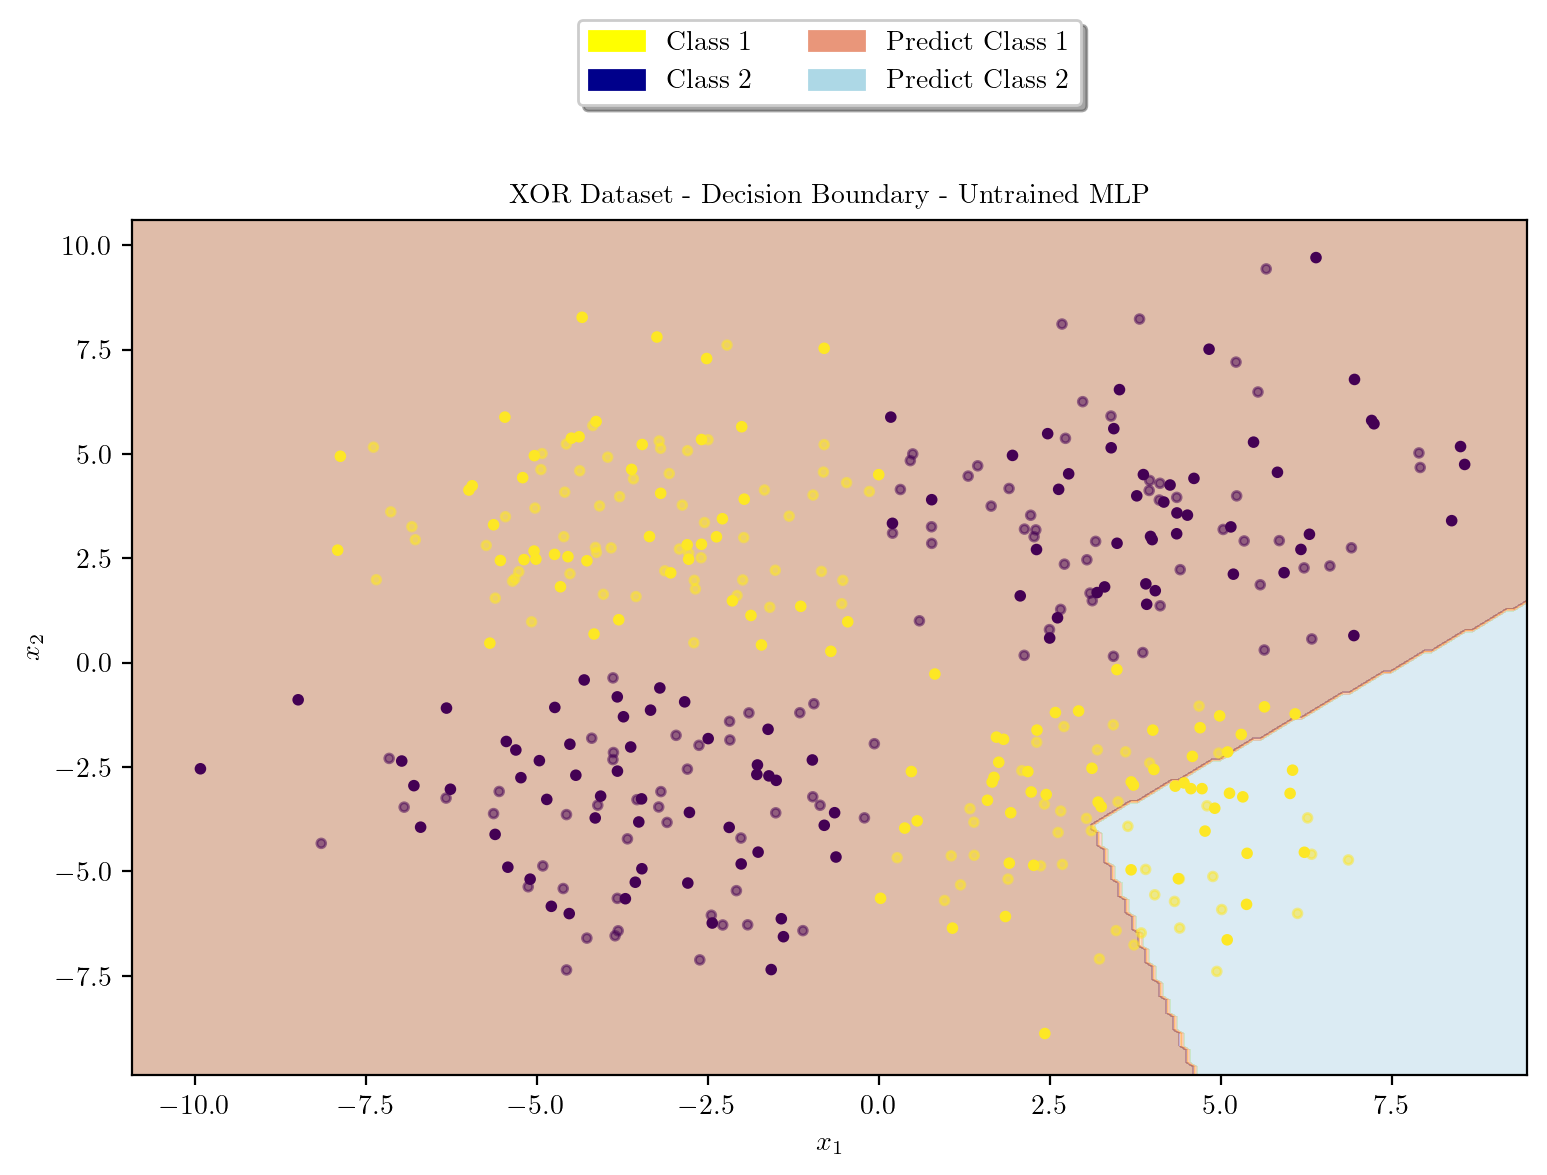

In [33]:
latexify(columns = 2, fig_width = 9)
model = XORMLP1(hidden_layer1 = 3)
plot_decision_boundary(X_train, X_test, y_train, y_test, model, "XOR Dataset - Decision Boundary - Untrained MLP")

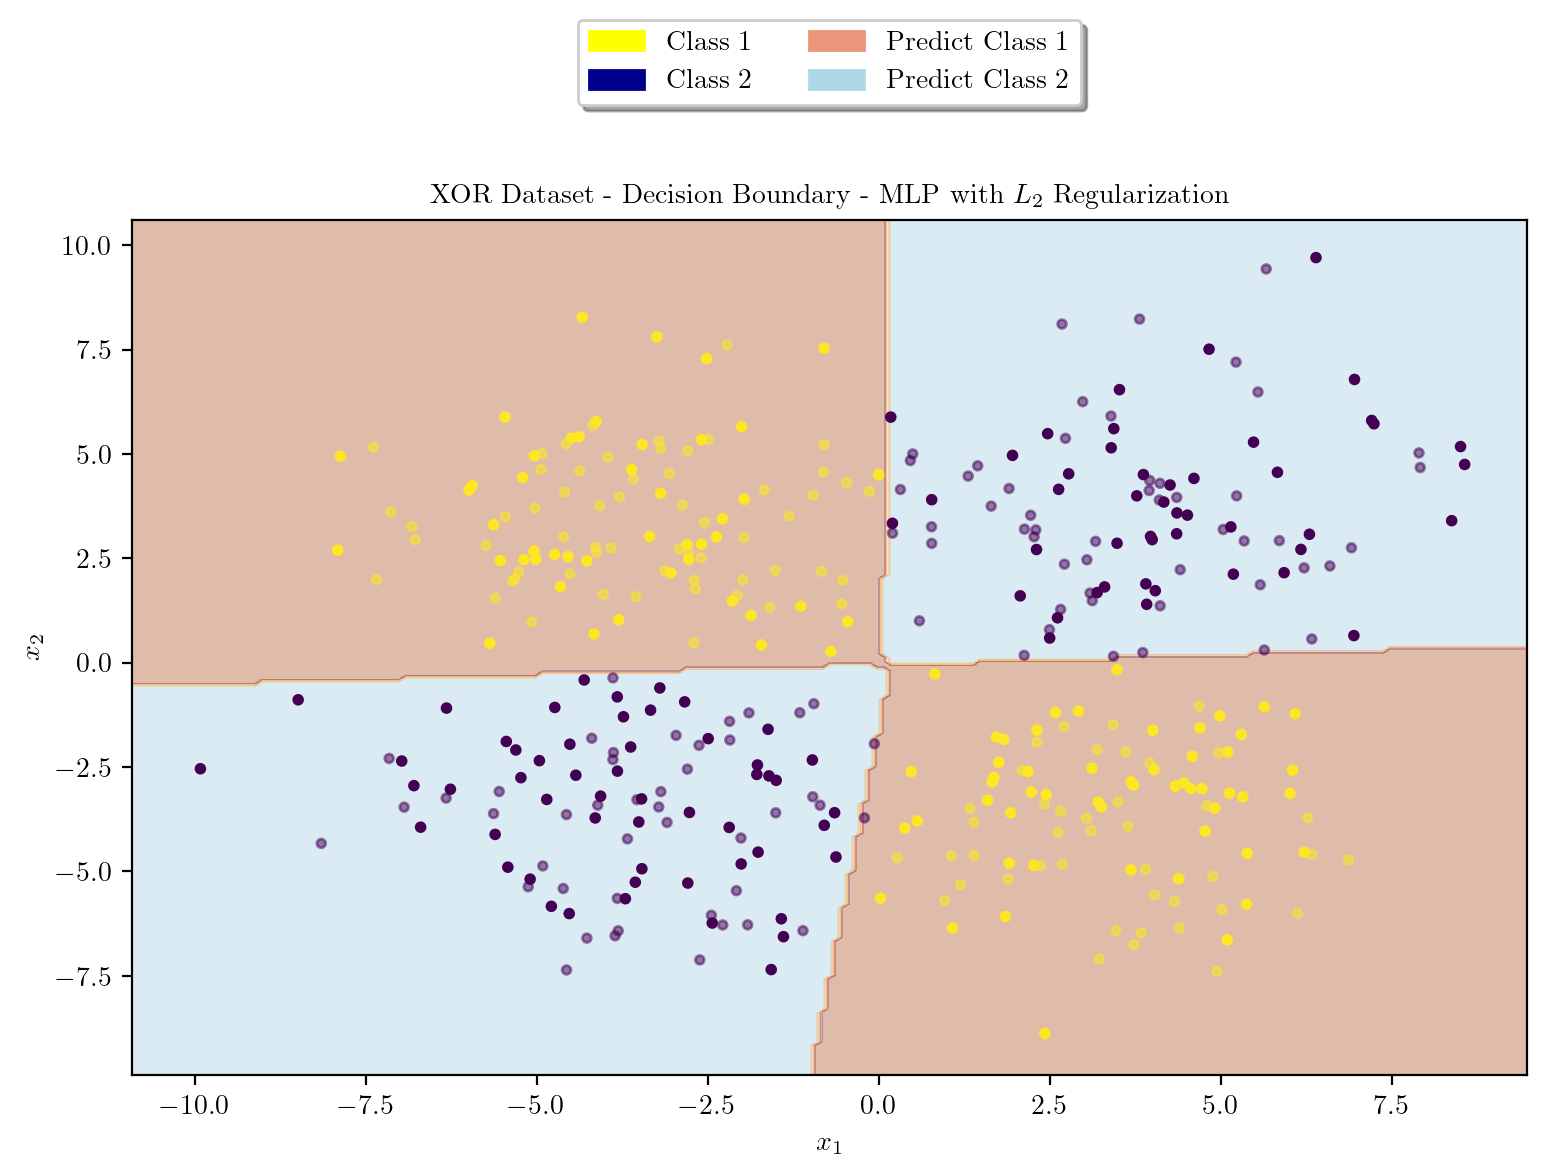

In [32]:
latexify(columns = 2, fig_width = 9)
plot_decision_boundary(X_train, X_test, y_train, y_test, model, r"XOR Dataset - Decision Boundary - MLP with $L_2$ Regularization")

# **Logistic Regression using Polynomial Features $[x_1^2, x_2^2, x_1x_2]$**

![](./media/SimpleLog.png)

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

poly = PolynomialFeatures(degree = 2, include_bias = False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train_poly, y_train)

y_train_pred = logreg.predict(X_train_poly)
y_test_pred = logreg.predict(X_test_poly)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Train Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)

Train Accuracy:  1.0
Test Accuracy:  0.98


/Users/guntas13/micromamba/lib/python3.9/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## **Plotting Decision Surface for Logistic Regression**

In [46]:
def plot_decision_boundary(X_train, X_test, y_train, y_test, model, title):
    X = np.concatenate([X_train, X_test], axis = 0)
    y = np.concatenate([y_train, y_test], axis = 0)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    poly = PolynomialFeatures(degree = 2, include_bias = False)
    meshgrid_poly = poly.fit_transform(np.c_[xx.ravel(), yy.ravel()])

    Z = model.predict(meshgrid_poly)

    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap = plt.cm.Paired, alpha=0.4)

    plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = "viridis", s = 10)
    plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = "viridis", s = 10, alpha = 0.5)

    yellow_patch = mpatches.Patch(color = "yellow", label = "Class 1")
    blue_patch = mpatches.Patch(color = "darkblue", label = "Class 2")
    pink_patch = mpatches.Patch(color = "darksalmon", label = "Predict Class 1")
    lblue_patch = mpatches.Patch(color = "lightblue", label = "Predict Class 2")
    plt.legend(handles = [yellow_patch, blue_patch, pink_patch, lblue_patch], loc = "upper center", bbox_to_anchor = (0.5, 1.25), ncol = 2, fancybox = True, shadow = True)

    plt.title(title)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.show()

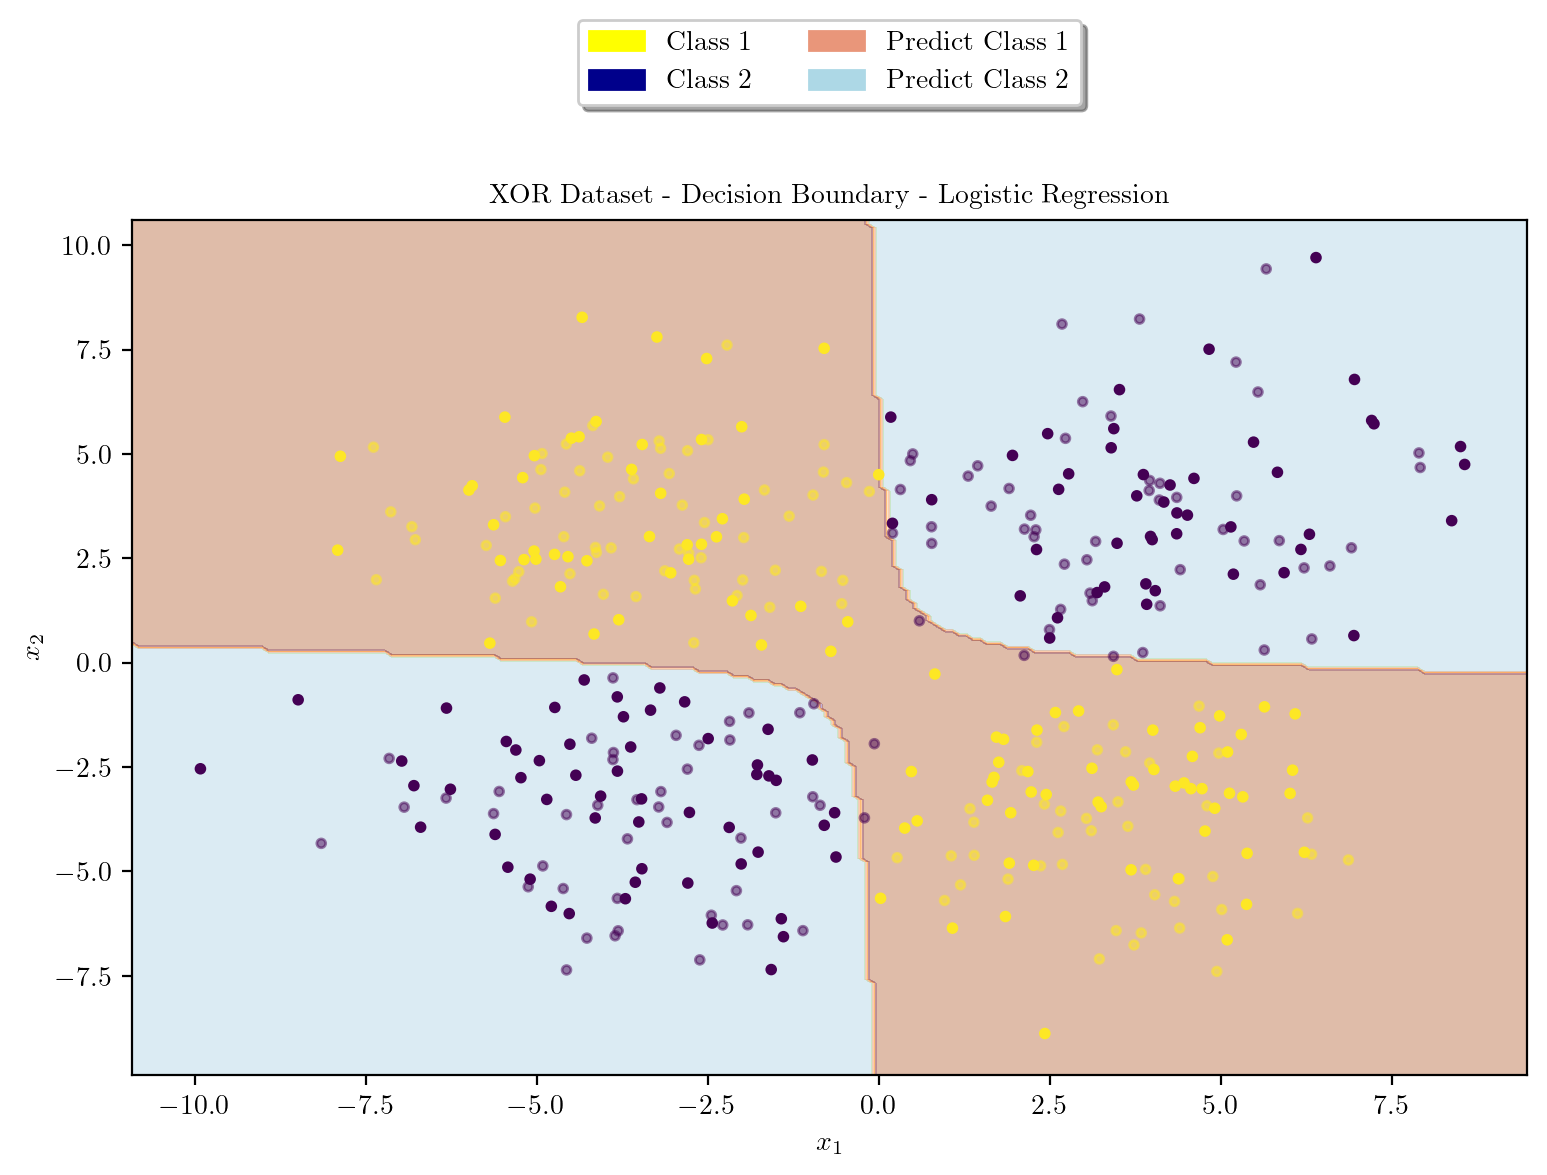

In [47]:
plot_decision_boundary(X_train_poly, X_test_poly, y_train, y_test, logreg, "XOR Dataset - Decision Boundary - Logistic Regression")